# Encuentra los parametros cosmologicos con datos de supernovas 

Desde fines de la década de 1990, cuando comenzo a presentarse evidencia de que la expansión del universo se está acelerando, las observaciones de supernovas de tipo Ia (SNeIa) han sido una de nuestras herramientas más importantes para medir la expansión cósmica en función del tiempo. Dado que una medida precisa de la evolución del factor de escala es probablemente la clave para caracterizar la energía oscura o establecer que la relatividad general debe modificarse en escalas cosmológicas, los datos limitados que nuestro universo nos brinda deben utilizarse con la mayor ventaja posible. Un elemento importante de esa tarea es el análisis estadístico más cuidadoso posible de los datos.

El supuesto fundamental que subyace en el pasado y el uso propuesto de las SNeIa para medir el historial de expansión es que son "velas estandartizadas". Es posible que ocurran cuando el material que se adhiere a una enana blanca de un compañero conduce la masa de la enana blanca por encima del máximo que puede soportar la presión de degeneración electrónica, el límite de Chandrasekhar de aproximadamente 1.4 masas solares. Debido a que el colapso ocurre en una masa crítica particular, todos los SNeIa son similares. Sin embargo, la variabilidad en varios factores, incluyendo la composición, la tasa de rotación y la tasa de acreción, puede llevar a diferencias mensurables en los observables de SN como una función del tiempo. De hecho, la magnitud intrínseca de la SNeIa cercana, cuyas distancias se conocen a través de medios independientes, muestra una dispersión bastante grande.

$\mu$ es el modulo de distancia de la supernva definido como:
$\mu = 25 - 5log_{10}h+5log_{10}(D^*_L)$

    

Donde $D^*_L = D_L(h=1)$ es la distancia luminosa que para un universo plano se puede definir como: $D_L(z) = \frac{c}{H0}(1+z)\left[\eta(1,\Omega_m)-\eta(\frac{1}{1+z},\Omega_m)\right]$,

con $\eta(a,\Omega_m) = 2\sqrt{s^3+1}\left[\frac{1}{a^4}-0.1540\frac{s}{a^3} + 0.4304\frac{s^2}{a^2} + 0.19097\frac{s^3}{a} + 0.066941s^4\right]^{-1/8}$

y: $s^3=(1-\Omega_m)/\Omega_m$

In [1]:
# Importamos librerias
%pylab inline
import numpy as np
import emcee
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import random
import scipy.optimize as op
import corner
plt.style.use('classic')

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = np.loadtxt('jla_mub.txt').T
cov_mat = np.loadtxt('jla_mub_covmatrix.dat').T
cov_mat = np.reshape(cov_mat,(-1,31))
invcov = np.linalg.inv(cov_mat)
H0 = 100
c = 3e5

### Construimos las funciones para evaluar el modelo:

In [3]:
def eta(a, Om):
    s3 = (1-Om)/Om 
    s2 = s3**(2/3)
    s = s3**(1/3)
    return 2*np.sqrt(s3+1)*((1/(a**4))-0.1540*s/(a**3)+0.4304*s2/(a**2)+0.19097*s3/a+(0.06694*s**4))**(-1/8)

def DL(z, H0, Om):
    return (c/H0)*(1+z)*(eta(1, Om)-eta(1/(1+z),Om))

def mu(z,H0,Om):
    return 25-5*np.log10(H0/100)+5*np.log10(DL(z, H0, Om))


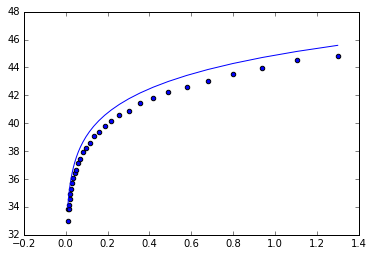

In [4]:
# Graficamos un conjuntp de datos
plot(data[0],mu(data[0],70,0.3))
scatter(data[0], data[1])

### Definimos una funcion para el Likelihood y una funcion para la cadena de Markov - Monte Carlo

Likelihood:

$\mathcal{L} \propto \prod_i^n \frac{1}{2\pi\sigma_i^2}\exp\left[ -\frac{(x_i -\mu)^2}{2\sigma_i^2} \right]$

Logaritmo del Likelihood: 

$\ln(\mathcal{L}) \propto -\sum_i^n \left[\frac{(x_i -\mu)^2}{2\sigma_i^2} \right]$

In [21]:
def lnlh(theta):
    modelo=mu(data[0], theta[0],theta[1])
    diferencia = data[1]-modelo
    u=0
    u = np.dot(diferencia, invcov)
    u = np.dot(u,diferencia.T)
    u = -0.5 * np.sum(u)
    return u

def Markov(theta1, thetap):
    p1 = lnlh(theta1)
    pp = lnlh(thetap)
    if(pp>p1):
        return thetap
    else:
        w = np.random.rand()
        if(pp-p1>np.log(w)):
            return thetap
        else:
            return theta1
    return

In [174]:
Nmuestras = 1000
sigma1 = 1
sigma2 = 0.1

Ncadenas = 8
thetas = [50,0.3]
cadenas = []

for j in range(Ncadenas):
    thetas = np.array([np.random.normal(np.random.uniform(50, 100), sigma1), np.random.normal(thetas[1], sigma2)])
    for i in range(Nmuestras):
        if i==0:
            cadena = thetas
        else:
            thetat = np.array([np.random.normal(thetas[0], sigma1), np.random.normal(thetas[1], sigma2)])
            thetanuevo = Markov(thetas, thetat)
            cadena = np.vstack((cadena, thetanuevo))
            thetas = thetanuevo
    if j==0:
        cadenas = cadena
    else:
        cadenas = np.vstack((cadenas, cadena))

/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [178]:
x1 = cadenas[0:Nmuestras,0]
y1 = cadenas[0:Nmuestras,1]
x2 = cadenas[Nmuestras+1:Nmuestras*2,0]
y2 = cadenas[Nmuestras+1:Nmuestras*2,1]
x3 = cadenas[2*Nmuestras+1:Nmuestras*3,0]
y3 = cadenas[2*Nmuestras+1:Nmuestras*3,1]
x4 = cadenas[3*Nmuestras+1:Nmuestras*4,0]
y4 = cadenas[3*Nmuestras+1:Nmuestras*4,1]
x5 = cadenas[4*Nmuestras+1:Nmuestras*5,0]
y5 = cadenas[4*Nmuestras+1:Nmuestras*5,1]
x6 = cadenas[5*Nmuestras+1:Nmuestras*6,0]
y6 = cadenas[5*Nmuestras+1:Nmuestras*6,1]
x7 = cadenas[6*Nmuestras+1:Nmuestras*7,0]
y7 = cadenas[6*Nmuestras+1:Nmuestras*7,1]
x8 = cadenas[7*Nmuestras+1:Nmuestras*8,0]
y8 = cadenas[7*Nmuestras+1:Nmuestras*8,1]

### Graficamos las cadenas generadas

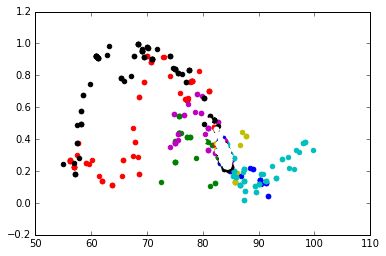

In [180]:
plt.scatter(x1, y1, color = 'g')
plt.scatter(x2, y2, color = 'r')
plt.scatter(x3, y3, color = 'y')
plt.scatter(x4, y4, color = 'b')
plt.scatter(x5, y5, color = 'c')
plt.scatter(x6, y6, color = 'm')
plt.scatter(x7, y7, color = 'k')
plt.scatter(x8, y8, color = 'w')

(0.15, 0.5)

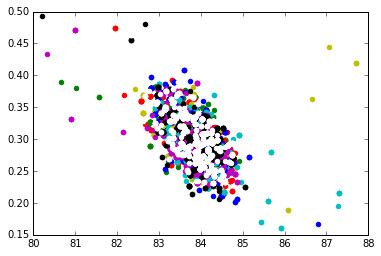

In [184]:
plt.scatter(x1, y1, color = 'g')
plt.scatter(x2, y2, color = 'r')
plt.scatter(x3, y3, color = 'y')
plt.scatter(x4, y4, color = 'b')
plt.scatter(x5, y5, color = 'c')
plt.scatter(x6, y6, color = 'm')
plt.scatter(x7, y7, color = 'k')
plt.scatter(x8, y8, color = 'w')
plt.xlim(80, 88)
plt.ylim(0.15, 0.5)